In [1]:
%matplotlib widget
import torch
from model import ContactTransformer
import os
from omegaconf import OmegaConf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import plotly.graph_objects as go

**Data Processing**

We employ a heuristic approach to smooth, filter, and normalize the data, ensuring it is optimally prepared for model input.

In [2]:
def process_data(file_path, max_s, min_s, start=None, slope_thres = 0.003, end_thres = 0.001):
    data_tbl = pd.read_csv(file_path, sep=',', engine='c', na_filter=False, low_memory=False)
    S = data_tbl[['sx','sy']]
    S = S.fillna(method='ffill').to_numpy()
    for i in range(S.shape[0]):
        if S[i, 0] == '':
            S[i, 0] = S[i-1, 0]
        if S[i, 1] == '':
            S[i, 1] = S[i-1, 1]
    S = S.astype(float)
    if start is not None:
        S = S[start:start+43000,:]
    else:
        S = S[42000:]
    if S.shape[0] < 60000:
        S = np.pad(S, ((0, 60000 - S.shape[0]), (0, 0)), 'edge')
    # # downsample 40000 points to 20000
    S = S[::2]
    # normalize signal value to (0, 1) based on its max and min values
    max_s = max_s 
    min_s = min_s
    S = np.clip(S, min_s, max_s)
    S = (S - min_s) / (max_s - min_s)
    
    S[:,0] = pd.Series(S[:,0]).rolling(window=200).mean().fillna(0).values
    S[:,1] = pd.Series(S[:,1]).rolling(window=200).mean().fillna(0).values
    
    # stack contact position and sensor matrix (n, traj_length, data_dim)
    S = S[199::200]
    S = S - S[0, :] + np.array([40000/(40000 + 30000), 40000/(40000 + 30000)])

    start_new = 0
    for i in range(1, S.shape[0]):
        if np.abs(S[i, 0] - S[i-1, 0]) > 0.001 or np.abs(S[i, 1] - S[i-1, 1]) > 0.001:
            start_new = i
            break
    start_new = start_new - 5
    S = S[start_new:start_new+100,:]

    threshold = 0.001
    end_thres = end_thres
    slope_threshold = slope_thres

    # Find the time point when the signals first change
    start_index = 0
    for i in range(1, S.shape[0]):
        if np.abs(S[i, 0] - S[i-1, 0]) > threshold or np.abs(S[i, 1] - S[i-1, 1]) > threshold:
            start_index = i
            break
    S[:start_index, :] = 4 / 7
    
    end_index = None
    for i in range(start_index+1, S.shape[0]):
        if np.abs(S[i, 0] - S[i-1, 0]) < threshold and np.abs(S[i, 1] - S[i-1, 1]) < threshold:
            end_index = i
            break
    
    end_index = None
    for i in range(S.shape[0]-1, 10, -1):
        if (np.abs(S[i-1, 0] - S[i, 0]) > end_thres or np.abs(S[i-1, 1] - S[i, 1]) > end_thres):
            end_index = i
            break
    if (abs(S[end_index, 0] - 4/7) > 0.03 or abs(S[end_index, 1] - 4/7) > 0.03):
        end_index = None
    if end_index is not None:
        end_index = end_index - 5

    # check for an overshoot pattern by detecting slope change
    overshoot_index = None
    
    for i in range(start_index + 1, S.shape[0]):
        slope_x = S[i, 0] - S[i-1, 0]
        slope_y = S[i, 1] - S[i-1, 1]
        if (slope_x > slope_threshold or slope_y > slope_threshold) and (S[i, 1] > (4/7)):
            overshoot_index = i
            continue
    if overshoot_index is not None:
        overshoot_index = overshoot_index - 1
    
    # Set the value of both sensor signals to 4/7 after the overshoot index or end index
    true_end = None
    if overshoot_index is not None and end_index is None:
        S[overshoot_index:, :] = 4 / 7
    elif end_index is not None and overshoot_index is None:
        S[end_index:, :] = 4 / 7
    elif end_index is not None and overshoot_index is not None:
        if overshoot_index < end_index:
            true_end = overshoot_index
        else:
            true_end = end_index
        S[true_end:, :] = 4/7

    # moving average filter
    Traj = data_tbl[['px']].to_numpy()
    origin_pos = Traj[0,0]

    if start is not None:
        Traj = Traj[start:start+43000,:]
    else:
        Traj = Traj[42000:]
    if Traj.shape[0] < 60000:
        Traj = np.pad(Traj, ((0, 60000 - Traj.shape[0]), (0, 0)), 'edge')
    Traj = Traj[::2]
    Traj = Traj[199::200]

    Traj = Traj[start_new:start_new+100]
    
    Traj[-1,:] = Traj[-2,:]

    sensor_signal = torch.from_numpy(S).type(torch.FloatTensor)
    sensor_signal = sensor_signal[:-1]
    traj = torch.from_numpy(Traj).type(torch.FloatTensor)
    traj = traj[1:]
    return sensor_signal, traj, origin_pos, start_index, end_index, overshoot_index, true_end

**Load Model**

Load the trained model in preparation for testing.

In [3]:
cfg = OmegaConf.load("./config/test.yaml")
model = ContactTransformer(**cfg)
print(model)
model.load_state_dict(torch.load("./ckpt/" + cfg.name + "/best.pth"))
device = torch.device(cfg.device) 
model.to(device)
mse_loss = torch.nn.MSELoss()        
model.eval()

ContactTransformer(
  (sensor_encoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoder_layer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dro

ContactTransformer(
  (sensor_encoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoder_layer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dro

**Testing and Visualization**

Load real-world data for testing and visualize the contact points with the 3D CAD model.

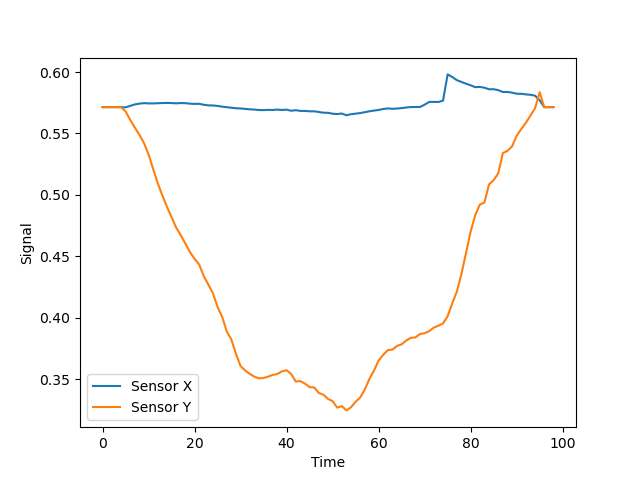

Average distance between predicted contact points and object:  0.00035628104003794926


In [4]:
object_file = "../data/test/bottle_1_mapped_sim.csv"
sensor_signal, traj, origin_pos, start_idx, end_idx, overshoot_idx, true_end = process_data(object_file, cfg.max_s, cfg.min_s)
sensor_signal = sensor_signal.to(cfg.device).unsqueeze(0)

mesh = trimesh.load_mesh("../data/test/bottle_1.stl")
mesh.apply_translation([0.10769475, -0.00521250, 0.026])
mesh.apply_translation([0.00407, 0.016, -0.04846])

vertices = mesh.vertices
faces = mesh.faces

mesh_to_draw =go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    opacity=0.7,
    color='paleturquoise',
    lighting=dict(
        ambient=0.8,
        diffuse=0.2,
        specular=0.1,
        roughness=1,
        fresnel=0
    ),
    lightposition=dict(
        x=-1,  # Adjust the light position as needed
        y=-1,
        z=0.5
    )
)

with torch.no_grad():
    # Plotting the sensor signal
    plt.figure()
    plt.plot(sensor_signal.cpu().numpy()[0,:, 0], label='Sensor X')
    plt.plot(sensor_signal.cpu().numpy()[0,:, 1], label='Sensor Y')
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.legend()
    plt.show()
    with torch.no_grad():
        pred_contact = model(sensor_signal)
    # (batch, traj_len, 3) and (batch, traj_len, 3)
    traj = traj.squeeze(0).cpu().numpy()
    pred_contact = pred_contact.squeeze(0).cpu().numpy()
    non_zero_start = np.where(np.linalg.norm(pred_contact, axis=1) > 0.01)[0][0]
    non_zero_end = np.where(np.linalg.norm(pred_contact, axis=1) > 0.01)[0][-1]

    if start_idx is not None:
        start_idx = start_idx if start_idx > non_zero_start else non_zero_start
    else:
        start_idx = non_zero_start

    if true_end is not None:
        end_idx = true_end if true_end < non_zero_end else non_zero_end
    else:
        end_idx = non_zero_end
    
    pred_contact[:, 0] = pred_contact[:, 0] + traj[:,0] - origin_pos
    mean_x = vertices[:, 0].mean()
    mean_y = vertices[:, 1].mean()
    mean_z = vertices[:, 2].mean()
    box_size = 0.5
    x_max = mean_x + box_size
    x_min = mean_x - box_size
    y_max = mean_y + box_size
    y_min = mean_y - box_size
    z_max = mean_z + box_size
    z_min = mean_z - box_size


    # Create the scatter plot for pred_contact points
    scatter = go.Scatter3d(
        x=pred_contact[start_idx:end_idx, 0],
        y=pred_contact[start_idx:end_idx, 1],
        z=pred_contact[start_idx:end_idx, 2],
        mode='markers',
        marker=dict(size=8, color='orange'),
        name='pred_contact'
    )

    # Create the figure
    fig = go.Figure(data=[mesh_to_draw, scatter])

    # Set the layout for the axes and figure size
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                showgrid=True,
                zeroline=True,
                showline=False,
                title='',
                backgroundcolor='lightcyan',
                gridcolor='lightgray',
                showticklabels=False,
                range=[x_min, x_max]
            ),
            yaxis=dict(
                showgrid=True,
                zeroline=True,
                showline=False,
                title='',
                backgroundcolor='lightcyan',
                gridcolor='lightgray',
                showticklabels=False,
                range=[y_min, y_max]
            ),
            zaxis=dict(
                showgrid=True,
                zeroline=True,
                showline=False,
                title='',
                backgroundcolor='lightcyan',
                gridcolor='lightgray',
                showticklabels=False,
                range=[z_min, z_max]
            ),
            aspectmode='cube',
            aspectratio=dict(x=1, y=1, z=1)
        ),
        scene_camera=dict(
        eye=dict(x=-1, y=-1, z=0.8),  # Set the camera position
        up=dict(x=0, y=0, z=0.5)           # Set the up direction
        ),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1000,  # Set the width of the figure
        height=800   # Set the height of the figure
    )
    # Show the plot
    fig.show()

closest_points, distance, _ = trimesh.proximity.closest_point(mesh, pred_contact[start_idx:end_idx])
average_distance = np.mean(distance)

print("Average distance between predicted contact points and object: ", average_distance)

